In [579]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
        
args = GENV(n_channels=1, n_samples=500, shuffle=False)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [580]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.latent_dims = 30
args.num_embed =512

# v = Variational_Autoencoder(args,
#                             v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
#                            )
v = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

v = v.to(args.device)

encoder = v.encoder
opt_enc = optim.Adam(encoder.parameters(), lr=0.0001)

decoder = v.decoder
opt_dec = optim.Adam(decoder.parameters(), lr=0.0001)

opt = optim.Adam(v.parameters(), lr = 0.0002043529186448577) # 0.005043529186448577 0.006819850049647945
# print(v)

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


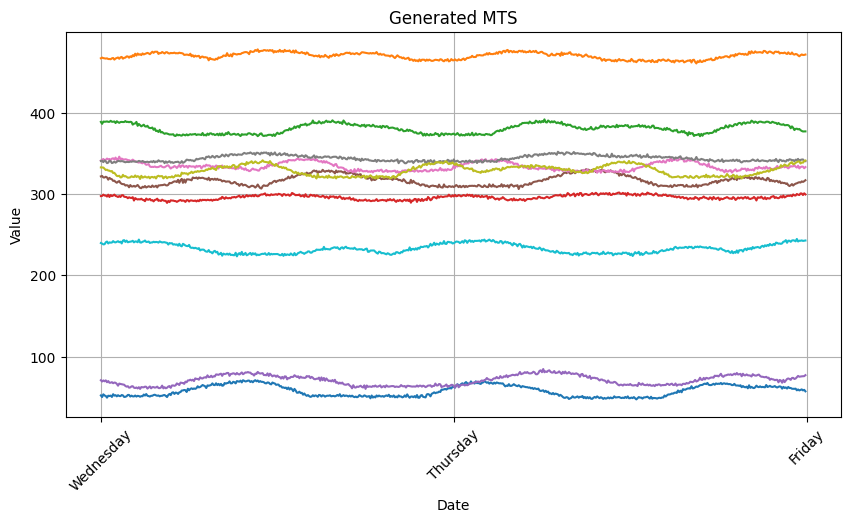

In [581]:
train_data, val_data, test_data = generate_labeled_data(args, effects, effect="both", occurance=2)

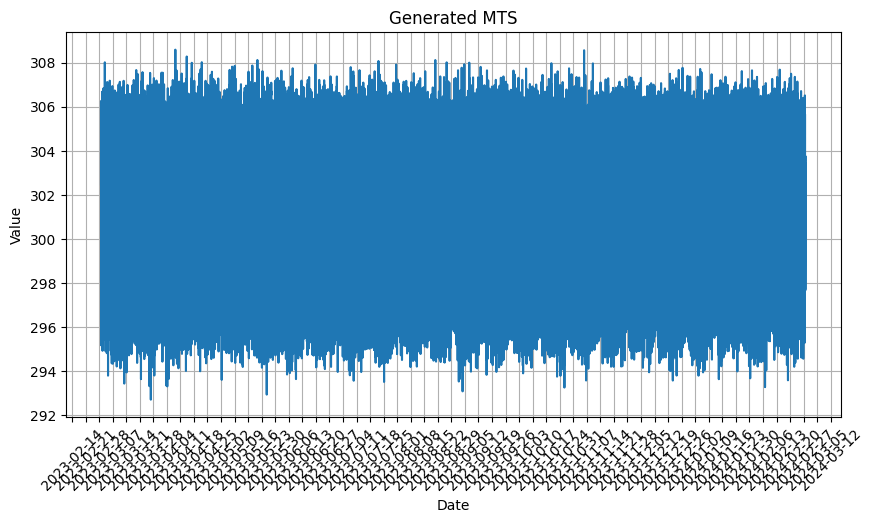

In [582]:
args.min_max=False
args.n_channels = 1
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args, effects, effect="Seasonality", occurance=2, return_gen=True)

In [542]:
data = train_data_long.dataset.data

In [416]:
data.std(dim=1, keepdim=True)

tensor([[1.0034],
        [5.1056]])

In [324]:
mean_global = data.mean(dim=1, keepdim=True)
std_global = data.std(dim=1, keepdim=True)
for i, (data, label, norm) in enumerate(train_data_long):
    denorm_data = revert_min_max(data, norm)
    mean_window = denorm_data.mean(dim=-1)
    std_window = denorm_data.std(dim=-1)

In [282]:
mean_window.shape

torch.Size([145, 2])

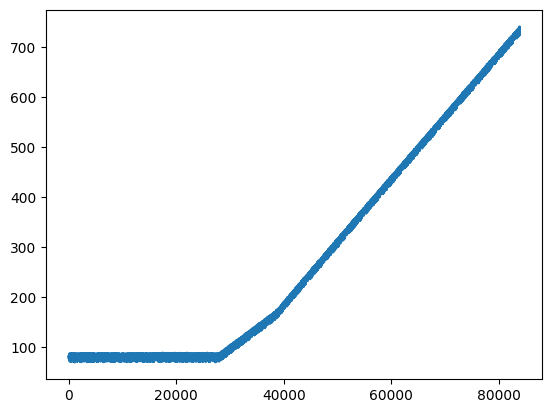

In [527]:
plt.plot(data.T[:])

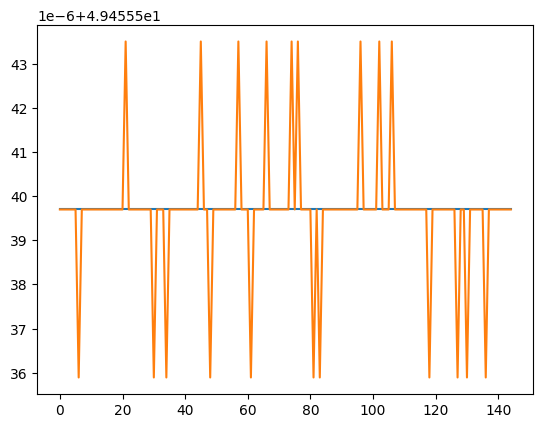

In [286]:
plt.plot(std_window)

In [583]:
def denoise_data(data):
    denoised = np.empty_like(data)
    for i, d in enumerate(data):
        denoised[i] = denoise(d.unsqueeze(0).cpu())
    return denoised

In [584]:
Origin_norm, REC_norm, _ = rebuild_TS_non_overlapping(v, train_data_long, args, keep_norm=True)

In [585]:
Origin_norm[:576*5,0].shape

torch.Size([2880])

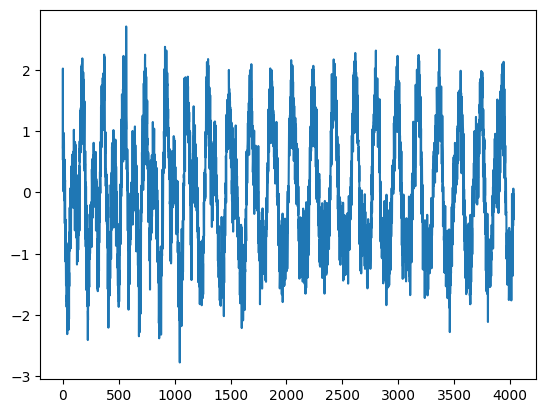

In [587]:
plt.plot(Origin_norm.cpu()[:288*14])

In [589]:
denoised = denoise_data(Origin_norm.T.cpu())

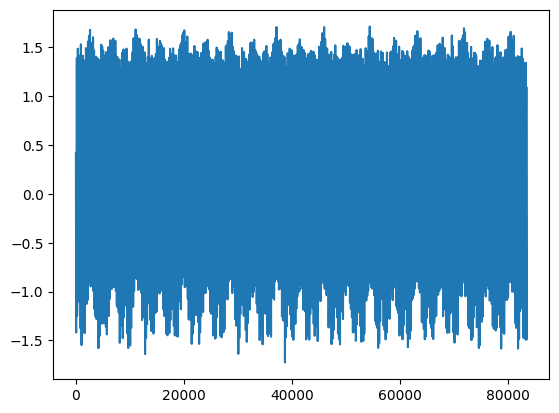

In [590]:
plt.plot(denoised.T)

In [591]:
denoised.shape

(1, 83520)

In [592]:
12*24

288

(41761,)


/tmp/ipykernel_11966/2087435955.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{a}' for a in range(1000)])


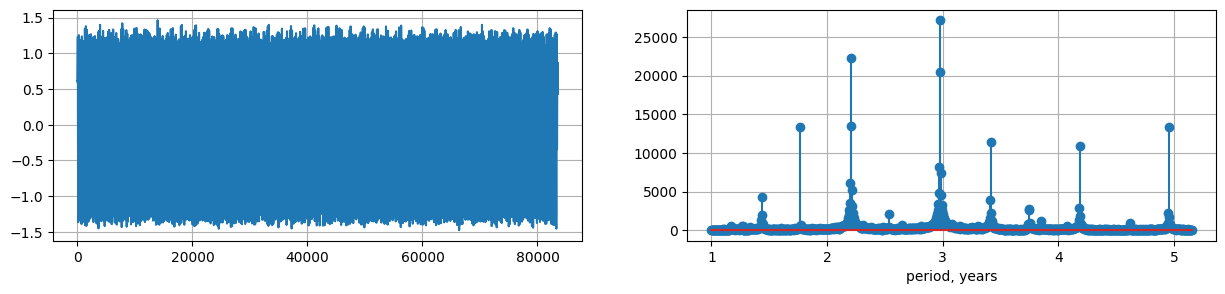

In [588]:
import scipy.fft as sf
import matplotlib.ticker as tck

N = denoised.shape[-1]
X = sf.rfft(denoised[0]) #/ N
freqs = sf.rfftfreq(n=N, d=288)

print(freqs.shape)
# Plot signal
fig, axes = plt.subplots(figsize=(15,3), ncols=2)
ax=axes[0]
ax.plot(denoised[0])
# ax.xaxis.set_major_locator(tck.MultipleLocator(50))
ax.grid()

# # Plot DFT
ax=axes[1]
extent = 1000#N
ax.set_xlabel('period, years')
ax.stem(freqs[:extent], abs(X[:extent]))
ticks = ax.get_xticks()
ax.set_xticklabels([f'{a}' for a in range(1000)])
# ax.invert_xaxis()
ax.grid()

In [571]:
Origin_norm.shape

torch.Size([83520, 1])

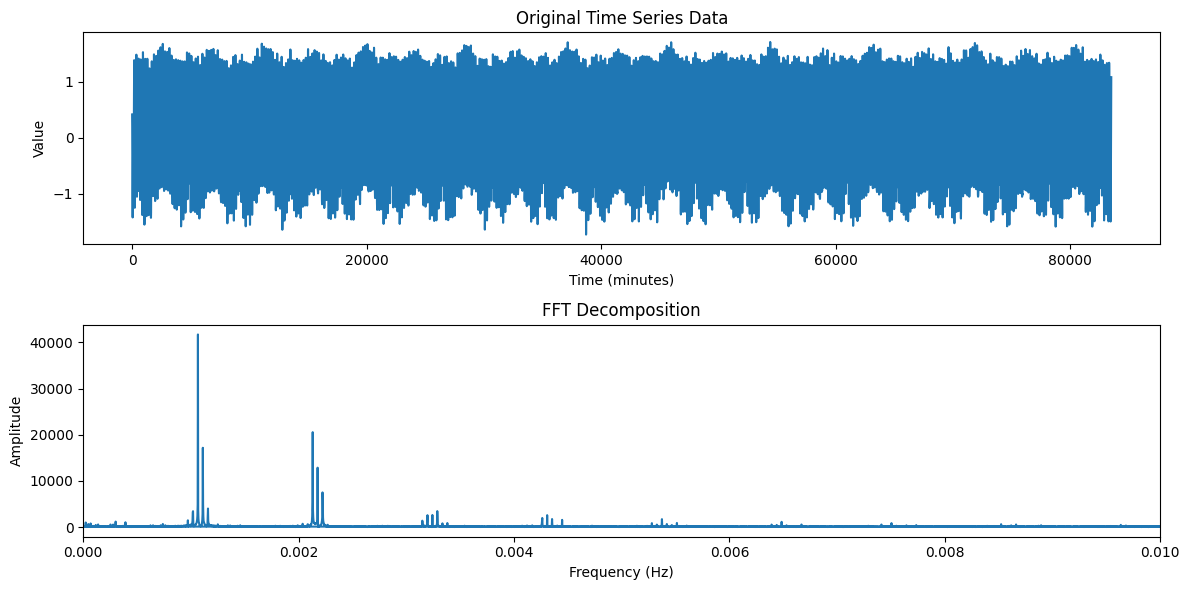

In [593]:
# Define your time series data with a 3-day seasonality
sampling_rate = 5  # 5 minutes between data points
num_points = Origin_norm.shape[0]  # Number of data points (assuming 5-minute intervals in a day)

# Create a time vector in minutes
time = np.arange(0, num_points)# * sampling_rate

# # Create a synthetic time series with a 3-day seasonality
# seasonality_freq = 1 / (3 * 24 * 60)  # Frequency in Hz (3 days in minutes)
# amplitude = 10  # Amplitude of the seasonality
# noise = np.random.normal(0, 1, num_points)  # Add some random noise
# data = amplitude * np.sin(2 * np.pi * seasonality_freq * time) + noise

# Perform FFT on the data
fft_result = np.fft.fft(Origin_norm[:,0].cpu())
frequencies = np.fft.fftfreq(denoised.shape[-1], d=sampling_rate)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, denoised[0])
plt.title("Original Time Series Data")
plt.xlabel("Time (minutes)")
plt.ylabel("Value")

# Plot the FFT results
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title("FFT Decomposition")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # Limit the x-axis to relevant frequencies

plt.tight_layout()
plt.show()


In [601]:
N = 50  # Adjust N as needed
max_amplitude_indices = np.argpartition(np.abs(fft_result), -N)[-N:]
# Get the corresponding frequency in Hertz
max_frequencies = frequencies[max_amplitude_indices]
positive_frequencies = max_frequencies[max_frequencies > 0]
print("Dominant Frequency:", positive_frequencies, "Hz")
np.set_printoptions(suppress=True)



Dominant Frequency: [0.00213602 0.00221983 0.0011159  0.00106082 0.00212644 0.00102011
 0.00110872 0.00324234 0.00430795 0.00328784 0.00319684 0.00101772
 0.00115661 0.00111351 0.00213362 0.00106801 0.001159   0.00106322
 0.00217672 0.00106561 0.00213123 0.00111111 0.00222222 0.00222462
 0.00212883] Hz


In [602]:
np.sort(7 / (positive_frequencies * 24 * 60))

array([1.12840467, 1.4785142 , 1.49926145, 1.52059925, 2.18514532,
       2.1875    , 2.18985976, 2.23322332, 2.27578475, 2.27833895,
       2.28089888, 2.28346457, 2.28603604, 4.19421488, 4.20289855,
       4.35622318, 4.3655914 , 4.375     , 4.38444924, 4.55156951,
       4.56179775, 4.57207207, 4.58239278, 4.76525822, 4.77647059])

In [598]:
np.sort(frs)

array([ 7.00912669, 11.4758742 ])

In [554]:
x_long, params_long, e_params_long = X_long.parameters()

In [603]:
frs = e_params_long["Seasonality"]["frequency_per_week"][0]

In [604]:
e_params_long["Seasonality"]["frequency_per_week"][0]

array([ 7.00912669, 11.4758742 ])

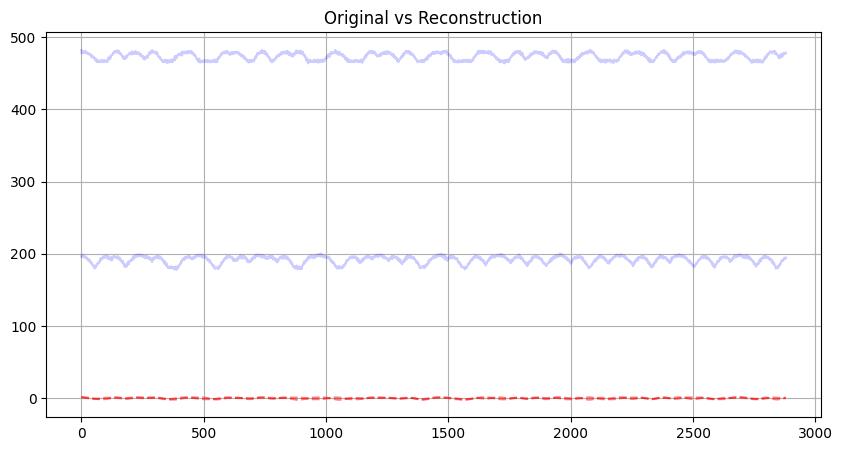

In [217]:
plot_rec(data.T[:args.L*5], denoised.T[:args.L*5])

In [214]:
denoised.shape

(2, 83520)

In [298]:
r = np.correlate(denoised[0][:args.L*20], denoised[0][:args.L], mode='full')[args.L*10:]
print(denoised.shape, r.shape)

(2, 83520) (6335,)


Text(0.5, 0, 'Lag (samples)')

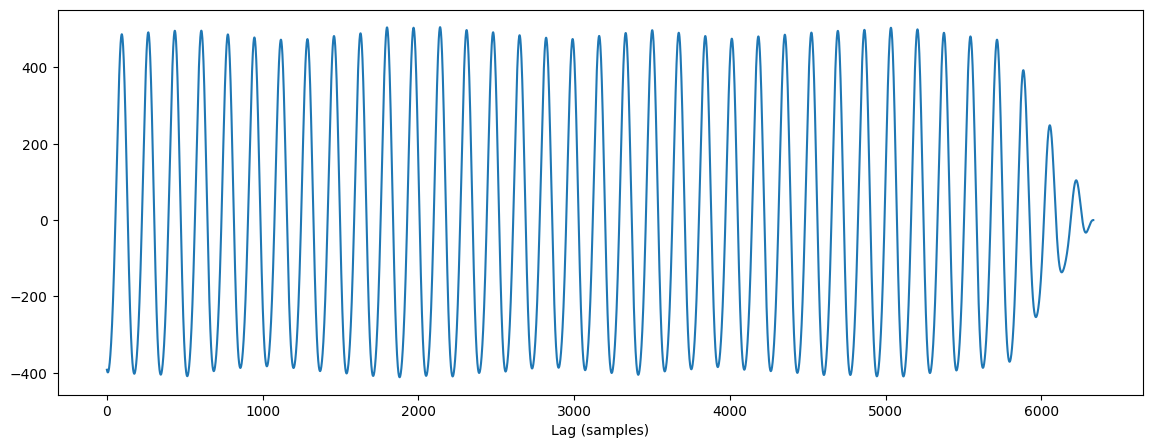

In [299]:
plt.figure(figsize=(14, 5))
plt.plot(r)
plt.xlabel('Lag (samples)')
# plt.xlim(0, 10000)

In [313]:
idx=np.argpartition(r, -10)[-10:]

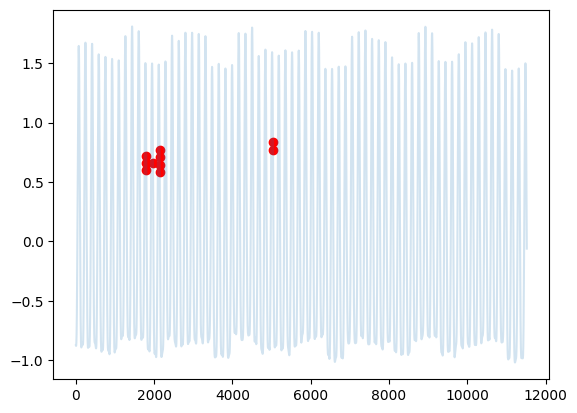

In [314]:
x= np.arange(len(denoised[0][:args.L*20]))
y = denoised[0][:args.L*20]
plt.plot(y, alpha=0.2)
plt.scatter(x[idx], y[idx], color='red', label='Dot at Index {}'.format(2901))


In [303]:
from statsmodels.graphics.tsaplots import plot_acf

In [304]:
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

def autocorr2(x,lags):
    '''manualy compute, non partial'''

    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

def autocorr3(x,lags):
    '''fft, pad 0s, non partial'''

    n=len(x)
    # pad 0s to 2n-1
    ext_size=2*n-1
    # nearest power of 2
    fsize=2**np.ceil(np.log2(ext_size)).astype('int')

    xp=x-np.mean(x)
    var=np.var(x)

    # do fft and ifft
    cf=np.fft.fft(xp,fsize)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real
    corr=corr/var/n

    return corr[:len(lags)]

def autocorr4(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

def autocorr5(x,lags):
    '''numpy.correlate, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean
    corr=np.correlate(xp,xp,'full')[len(x)-1:]/var/len(x)

    return corr[:len(lags)]

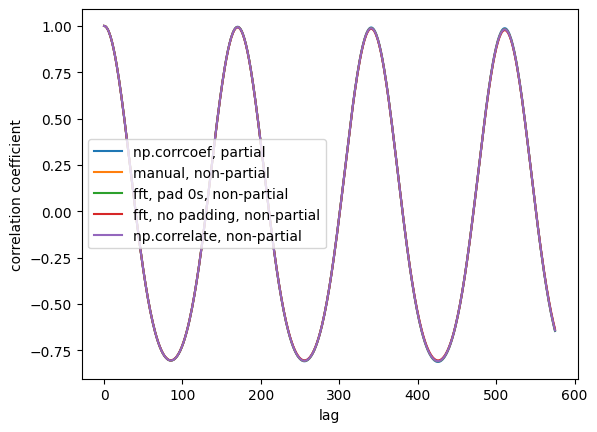

In [305]:
y=[28,28,26,19,16,24,26,24,24,29,29,27,31,26,38,23,13,14,28,19,19,\
            17,22,2,4,5,7,8,14,14,23]
y=np.array(y).astype('float')

# lags=range(15)
lags=range(args.L)
fig,ax=plt.subplots()

for funcii, labelii in zip([autocorr1, autocorr2, autocorr3, autocorr4,
    autocorr5], ['np.corrcoef, partial', 'manual, non-partial',
        'fft, pad 0s, non-partial', 'fft, no padding, non-partial',
        'np.correlate, non-partial']):

    cii=funcii(denoised[0],lags)
#     print(labelii)
#     print(cii)
    ax.plot(lags,cii,label=labelii)

ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.legend()
plt.show()

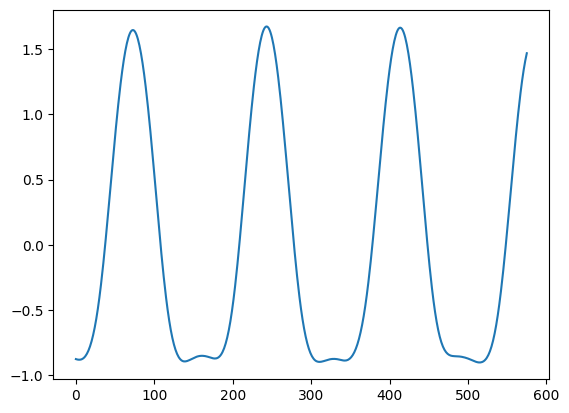

In [306]:
plt.plot(denoised[0][:576])

In [307]:
?plot_acf

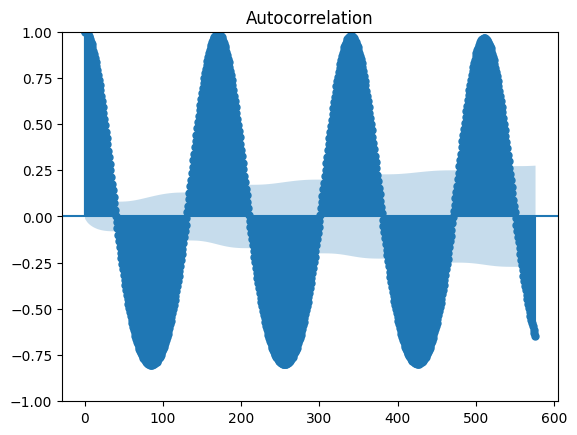

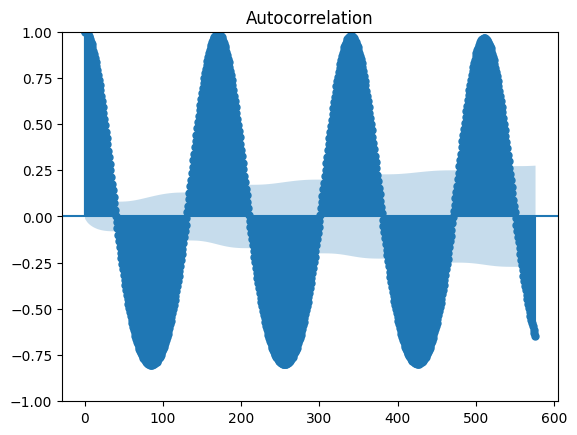

In [309]:
plot_acf(denoised[0][:576*40], lags=576*1)

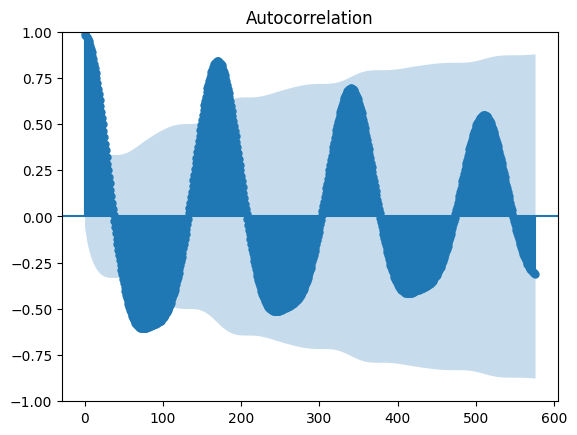

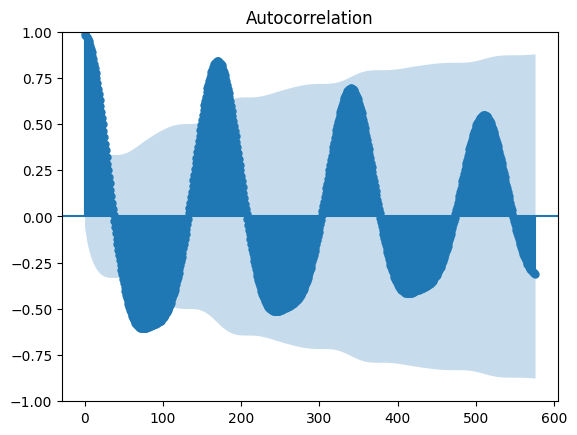

In [310]:
plot_acf(Origin_norm.T[0][:576*2].cpu(), lags=576*1)

In [311]:
fft_signal, freqs = fft_freq(denoised[0][:2000], args.step*60, 10)

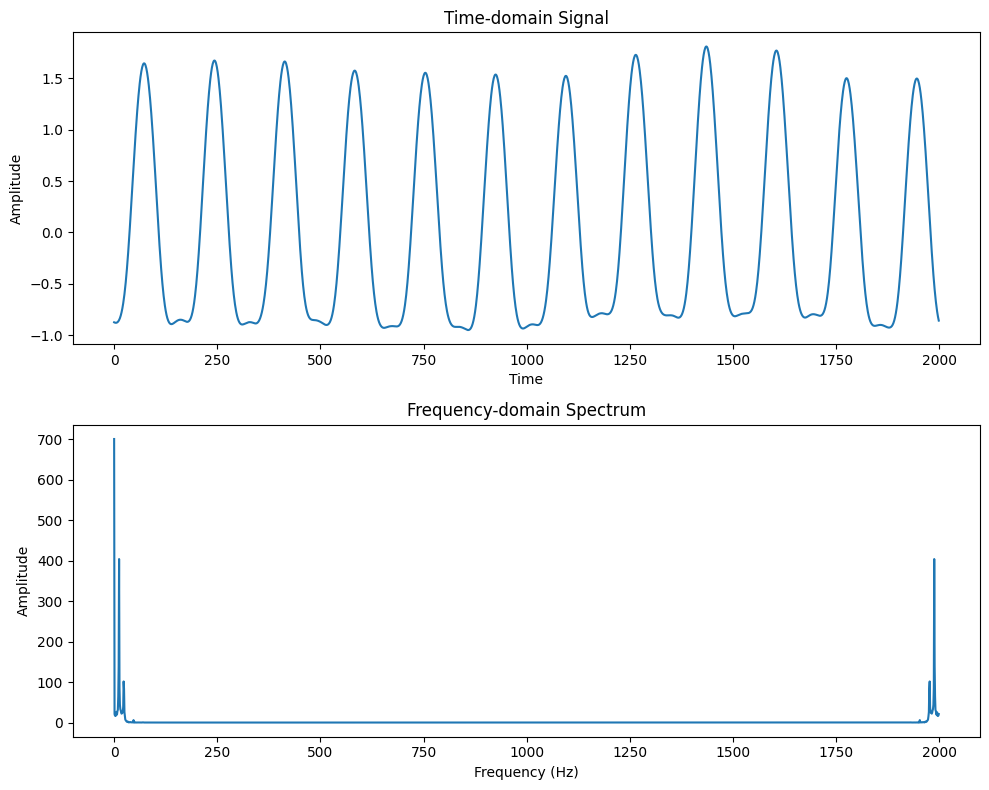

Dominant Frequency: [ 0.     1.728 -1.728 -1.584  1.584  3.312 -3.312  1.872 -1.872 -3.456
  3.456 -1.44   1.44  -2.016  2.016  3.168 -3.168  2.16  -2.16   1.296] Hz
Dominant Amplitude: [700.55273  403.97562  403.97562  139.17421  139.17421  101.54321
 101.54321   85.815414  85.815414  83.31932   83.31932   65.075
  65.075     44.328068  44.328068  38.753223  38.753223  33.267147
  33.267147  31.328114]


In [312]:
plot_fft(denoised[0][:2000], fft_signal, freqs)

In [58]:
import tsfel
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain("spectral")

# Extract features
X = tsfel.time_series_features_extractor(cfg, data.T, fs=1/5, window_size=args.L, overlap=0)
# Y = tsfel.time_series_features_extractor(cfg, denoised)

*** Feature extraction started ***



*** Feature extraction finished ***


In [51]:
?tsfel.time_series_features_extractor

In [59]:
import pandas as pd
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# X.T.columns = ["val"]
X.T

,0,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
0_FFT mean coefficient_0,122.461,170.533,197.777,246.101,192.077,194.615,178.720,154.806,105.768,59.161,...,64.599,40.775,5.530,0.841,2.509,31.486,80.275,116.943,123.303,211.849
0_FFT mean coefficient_1,2294.586,1919.005,1628.834,1770.980,2006.093,2028.584,2293.307,2326.922,2873.659,3099.236,...,2073.820,4308.808,5258.072,4556.608,4382.634,5537.316,5216.296,5475.068,4506.649,5557.896
0_FFT mean coefficient_10,206.542,177.248,418.546,241.207,187.146,138.373,65.304,140.635,66.248,97.978,...,43.072,94.134,82.454,138.860,108.425,114.099,148.196,188.350,314.470,362.180
0_FFT mean coefficient_100,13.760,0.756,15.874,11.442,6.084,10.851,0.773,17.978,3.138,1.843,...,3.459,1.446,23.576,4.086,2.067,5.253,25.649,13.319,6.789,0.022
0_FFT mean coefficient_101,2.716,31.314,5.477,6.307,12.924,22.865,1.029,2.290,0.043,25.530,...,1.219,10.820,9.355,1.289,3.839,3.241,0.101,6.360,4.505,0.785
0_FFT mean coefficient_102,13.267,6.863,1.896,14.933,0.365,9.202,0.603,13.618,1.811,1.087,...,13.524,3.012,14.845,6.957,9.621,7.470,32.131,29.650,37.056,10.615
0_FFT mean coefficient_103,19.452,16.515,7.418,13.663,22.721,5.541,8.297,14.212,1.592,2.086,...,4.487,25.223,9.046,14.769,4.483,12.003,17.985,3.155,32.542,6.361
0_FFT mean coefficient_104,10.780,14.428,8.753,18.674,3.711,14.249,6.019,14.587,11.504,10.859,...,34.722,6.166,4.080,16.628,22.754,17.551,12.348,17.467,5.384,12.883
0_FFT mean coefficient_105,3.820,0.091,23.638,0.452,3.178,3.975,16.334,11.244,3.990,6.382,...,15.126,7.384,20.578,6.160,23.142,3.922,5.722,24.407,5.625,6.365
0_FFT mean coefficient_106,2.482,2.492,0.690,0.249,21.142,0.677,1.204,2.903,12.639,25.723,...,9.081,1.605,5.073,31.577,15.845,15.218,9.277,2.572,13.726,8.888
